In [1]:
import os
import pandas as pd
import numpy as np
import cooler
import bioframe as bf

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

figure_width = 5
matplotlib.rcParams['font.size'] = 10
saveFigs = True 
if saveFigs == True:
    figure_path = '../figs/figure1/'
    os.makedirs(figure_path, exist_ok=True)
    # to save inkscape-friendly svgs
    new_rc_params = {'text.usetex': False,
                     "svg.fonttype": 'none'}
    matplotlib.rcParams.update(new_rc_params)



In [2]:
# load cooler at 50kb resolution from the mcool
cooler_file = '/pollard/data/wynton/consortia/4DN/rao2014/GM12878/4DNFIXP4QG5B.mcool'
resolution = 50000
hic_cooler = cooler.Cooler(cooler_file+'::resolutions/'+str(resolution))

In [3]:
hmm_track = pd.read_csv('../annotations/GM12878_hg38_50kb.tsv', sep='\t')

if (hmm_track['end'].values[0]-hmm_track['start'].values[0]) !=  resolution: 
    raise ValueError('resolution mismatch, check files')

hmm_track.head()


,chrom,start,end,KR,VC,VC_SQRT,weight,GC,E1,E2,E3,binary,HMM2,HMM3,HMM3P
0,chr1,0,50000,0.012247,0.001838,0.032337,NaN,0.484250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,50000,100000,0.047586,0.010207,0.076204,NaN,0.376740,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,100000,150000,0.050368,0.015204,0.093003,NaN,0.429960,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,150000,200000,0.059842,0.013402,0.087317,NaN,0.486340,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,200000,250000,NaN,0.000232,0.011488,NaN,0.480564,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# defining colors for plotting segmentation maps

names = {'HMM3': ['B', 'M', 'A', 'N','N'], 
         'HMM3P':['B', 'Mbb', 'M', 'Maa', 'A', 'N'],
         'binary':['B', 'A', 'N','N','N']
        }

nan_color = 5
pallete={ 'HMM3' :   np.array([0, 2, 4, nan_color, nan_color, nan_color]), 
          'HMM3P' :  np.array([0, 1, 2, 3, 4, nan_color]), 
          'binary' : np.array([0, 4, nan_color, nan_color, nan_color, nan_color])
         }

colordict={'B':'#74add1',
           'Mbb':'#e0f3f8',
           'M':'#ffffbf',
           'Maa':'#fdae61',
           'A':'#f46d43',
           'N':'#f8f8f8'}

def hex_to_rgb(hex_val):
    hex_val = hex_val.lstrip('#')
    hlen = len(hex_val)
    return tuple(int(hex_val[i:i+hlen//3], 16) for i in range(0, hlen, hlen//3))
   
cmap = np.array(list([ np.array(hex_to_rgb(colordict[key]))/255 for key in colordict.keys()]))

In [5]:
# utilities for plotting segmentations as colored heatmaps

def track_to_mat(hmm_track, region, annotation_type, pallete, heatmap_width = 5, horizontal=True):
    y_sig = bf.select(hmm_track, region)[annotation_type].values
    mat = np.tile(y_sig.reshape(1,-1), (heatmap_width, 1))
    mat[np.isnan(mat)] = nan_color
    mat = mat.astype(int)
    mat_c = pallete[annotation_type][mat]
    if not horizontal:
        mat_c = mat_c.T
    return mat_c

def plot_track(hmm_track, region, annotation_type, pallete):
    plt.figure(figsize=(figure_width, figure_width/10))
    mat_c = track_to_mat(hmm_track, region, annotation_type, pallete, horizontal=True)
    im = plt.imshow(mat_c,cmap=matplotlib.colors.ListedColormap(cmap), vmin=0, vmax=5, aspect='auto')
    
    # handling the legend
    values = pallete[annotation_type]
    colors = [ im.cmap(im.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors[i], label=names[annotation_type][i] ) 
               for i in range(len(np.unique(names[annotation_type])) )]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.axis('off');

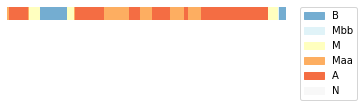

In [6]:
region1 = 'chr19:7,000,000-20,000,000'
annotation_type = 'HMM3P'
plot_track(hmm_track, region1, annotation_type, pallete)
plt.ylim([-2,1])
if saveFigs:
    plt.savefig(figure_path+'segmap_'+region1.replace(',','')+'_'+annotation_type+'.svg', bbox_inches='tight')

/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


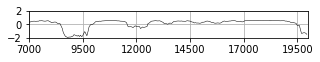

In [7]:
plt.figure(figsize=(figure_width, figure_width/10))
e1 = bf.select(hmm_track, region1)['E1'].values
plt.plot(e1,color=[0,0,0],lw=.5)
plt.ylim([-2,2])
plt.grid(True)
plt.yticks([-2,0,2])
xmax = len(e1)
plt.xlim([0, (xmax)])
ax = plt.gca()
chrm1, start1, end1 = bf.parse_region(region1)
xticklabels = ((ax.xaxis.get_ticklocs()*resolution/1e3)+(start1)/1e3).astype(int)
ax.xaxis.set_ticklabels(xticklabels);
if saveFigs:
    plt.savefig(figure_path+'e1_'+region1.replace(',','')+'.svg')

In [8]:
def plotmap(hic_cooler, hmm_track, region1, region2, annotation_type, plotColorbar=True):

    fig= plt.figure(figsize = (figure_width, figure_width))
    gs = gridspec.GridSpec(20, 20, figure=fig, wspace=2, hspace=2)

    # plot vertical segmentation map
    ax0= plt.subplot(gs[2:, 0:2])
    mat_c = track_to_mat(hmm_track, region2, annotation_type, pallete, horizontal=False)
    ax0.matshow(mat_c,cmap=matplotlib.colors.ListedColormap(cmap), vmin=0, vmax=5, aspect='auto')
    ax0.axis('off')
    ax0.margins(0)
    ax0.xaxis.tick_top()
    ax0.yaxis.tick_right()
    plt.yticks(rotation=90)

    # plot horizontal segmentation map
    ax1= plt.subplot(gs[0:2, 2:])
    mat_c = track_to_mat(hmm_track, region1, annotation_type, pallete, horizontal=True)
    ax1.matshow(mat_c,cmap=matplotlib.colors.ListedColormap(cmap), vmin=0, vmax=5, aspect='auto')
    ax1.axis('off')
    ax1.margins(0)
    ax1.set_xlabel('Position along Chr19 (50Kb)')

    # plot Hi-C map with overlaid lines
    ax2 = plt.subplot(gs[2:, 2:])
    
    mat = hic_cooler.matrix(balance=True).fetch(region2, region1)
    res = hic_cooler.binsize
    im = ax2.matshow(np.log10(mat + 5e-6),cmap = 'YlOrRd', aspect='auto', interpolation ='none')
    
    ymax, xmax = mat.shape
    y_sig1 = bf.select(hmm_track, region1)[annotation_type].values
    y_sig2 = bf.select(hmm_track, region2)[annotation_type].values
    vlines = (np.where(np.abs(np.diff(y_sig1))>0)[0]+1)
    hlines = (np.where(np.abs(np.diff(y_sig2))>0)[0]+1)
    ax2.vlines(vlines, ymin=0, ymax=(ymax),color=[0,0,0,.9995])
    ax2.hlines(hlines, xmin=0, xmax=(xmax), 
               colors=rc('lines', linewidth=0.4, color='black'))
    plt.xlim([0, (xmax-1)])
    plt.ylim([(ymax-1), 0])
        
    ax2.yaxis.set_ticks_position('right')
    chrm2, start2, end2 = bf.parse_region(region2)
    yticklabels = ((ax2.yaxis.get_ticklocs()*res/1e3)+(start2)/1e3).astype(int)
    ax2.yaxis.set_ticklabels(yticklabels)
    
    ax2.xaxis.set_ticks_position('bottom')
    chrm1, start1, end1 = bf.parse_region(region1)
    xticklabels = ((ax2.xaxis.get_ticklocs()*res/1e3)+(start1)/1e3).astype(int)
    ax2.xaxis.set_ticklabels(xticklabels)
    
    if plotColorbar:
        cbar_ax = fig.add_axes([1.05, 0.2, 0.025, 0.3])
        cbar = fig.colorbar(im, cax=cbar_ax, shrink = .7, label='log10 contact freq')
    
    return fig

/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator


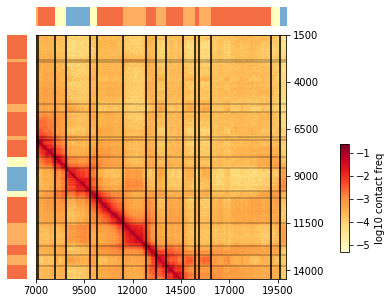

In [9]:
region2 = 'chr19:1,500,000-14,500,000'
region1 = 'chr19:7,000,000-20,000,000'
annotation_type = 'HMM3P'
fig  = plotmap(hic_cooler, hmm_track, region1, region2, annotation_type)
if saveFigs:
    plt.savefig(figure_path+'hicseg_'+region1.replace(',','')+'_'+
                region2.replace(',','')+annotation_type+'.svg',
                bbox_inches="tight")

/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator


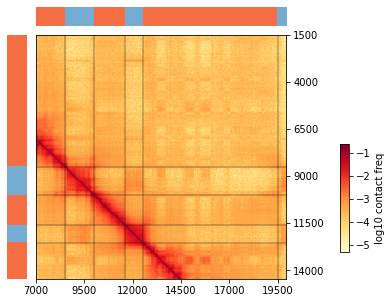

In [10]:
region2 = 'chr19:1,500,000-14,500,000'
region1 = 'chr19:7,000,000-20,000,000'
annotation_type = 'binary'
fig  = plotmap(hic_cooler, hmm_track, region1, region2, annotation_type)
if saveFigs:
    plt.savefig(figure_path+'hicseg_'+region1.replace(',','')+'_'+
                region2.replace(',','')+annotation_type+'.svg',
                bbox_inches="tight")

/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator


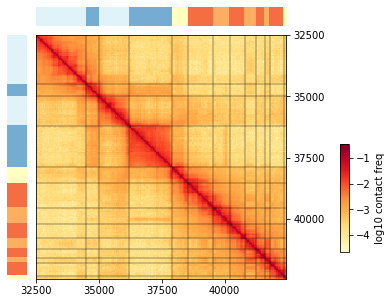

In [11]:
%matplotlib inline
annotation_type= 'HMM3P'
region1 = 'chr19:32,500,000-42,500,000'
region2 = region1
fig = plotmap(hic_cooler, hmm_track, region1, region2, annotation_type)

/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator


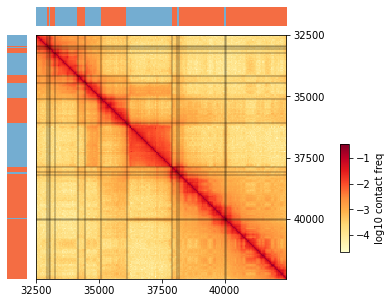

In [12]:
%matplotlib inline
annotation_type = 'binary'
region1 = 'chr19:32,500,000-42,500,000'
region2 = region1
fig = plotmap(hic_cooler, hmm_track, region1, region2, annotation_type)

/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator


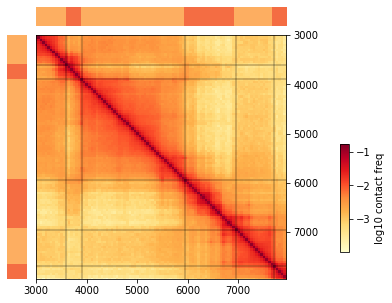

In [31]:
hmm_track = pd.read_csv('../annotations/GM12878_hg38_50kb.tsv', sep='\t')
cooler_file = '/pollard/data/wynton/consortia/4DN/rao2014/GM12878/4DNFIXP4QG5B.mcool'
resolution = 50000
hic_cooler = cooler.Cooler(cooler_file+'::resolutions/'+str(resolution))

annotation_type = 'HMM3P'
region1 = 'chr1:3,000,000-8,000,000'
region2 = region1
fig = plotmap(hic_cooler, hmm_track, region1, region2, annotation_type)
if saveFigs:
    plt.savefig(figure_path+'GM12878_hicseg_'+region1.replace(',','')+'_'+
                region2.replace(',','')+annotation_type+'.svg',
                bbox_inches="tight")

/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator


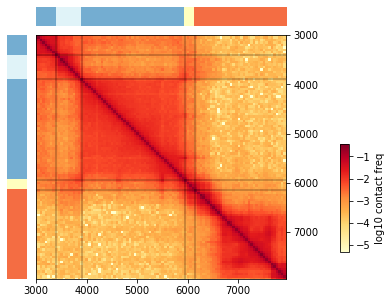

In [32]:
hmm_track = pd.read_csv('../annotations/IMR90_hg38_50kb.tsv', sep='\t')
cooler_file = '/pollard/data/wynton/consortia/4DN/rao2014/IMR90/4DNFIJTOIGOI.mcool'
resolution = 50000
hic_cooler = cooler.Cooler(cooler_file+'::resolutions/'+str(resolution))

annotation_type = 'HMM3P'
region1 = 'chr1:3,000,000-8,000,000'
region2 = region1
fig = plotmap(hic_cooler, hmm_track, region1, region2, annotation_type)
if saveFigs:
    plt.savefig(figure_path+'IMR90_hicseg_'+region1.replace(',','')+'_'+
                region2.replace(',','')+annotation_type+'.svg',
                bbox_inches="tight")